In [2]:
import numpy as np
np.random.seed(101)
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
import sklearn.metrics


In [3]:
properties = pd.read_csv("dataset/data_kaggle.csv")

pandas.core.frame.DataFrame

In [3]:
properties.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


In [4]:
# Price

In [5]:
# remove all entries with missing prices(by isna())
properties = properties.loc[~properties["Price"].isna()]

In [6]:
# make sure that every remaining entries 
# matches the same format of "RM" followed by commas and digits.
incorrect_entries = np.sum(~properties["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


In [7]:
# Strip the price of the "RM" as well as commas
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)
    
properties["Price"] = properties["Price"].apply(strip_price)

In [8]:
# Location

In [9]:
# make everything lower case for location
# Additionally, remove the city name because we only focus on Kuala lumpur
properties["Location"] = properties["Location"].str.lower()
properties["Location"] = properties["Location"].str.replace(r", kuala lumpur$", "")

In [10]:
# display the unique location values to check is it reasonably standardized
sorted(properties["Location"].unique())

['adiva desa parkcity',
 'alam damai',
 'ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bandar sri damansara',
 'bandar tasik selatan',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit  persekutuan',
 'bukit bintang',
 'bukit damansara',
 'bukit jalil',
 'bukit kiara',
 'bukit ledang',
 'bukit tunku (kenny hills)',
 'canary residence',
 'casa rimba',
 'chan sow lin',
 'cheras',
 'city centre',
 'country heights damansara',
 'cyberjaya',
 'damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'duta nusantara',
 'dutamas',
 'federal hill',
 'gombak',
 'gurney',
 'happy garden',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'jalan u-thant',
 'jinjang',
 'kemensah',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kota damansara',
 'kuala lumpur',
 'kuchai lama',
 'landed sd',
 'mid valley city',
 'mont kiara',
 'off gasing indah,',
 

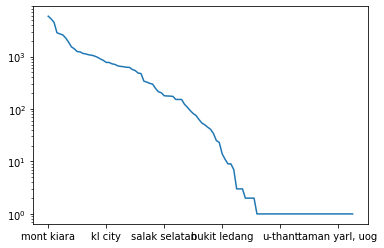

In [11]:
# remove the frequency of locations with fewer than 100
properties["Location"].value_counts().plot(logy=True);

In [12]:
# remove
significant_locations = properties["Location"].value_counts()[
    properties["Location"].value_counts() >= 100].index

properties = properties.loc[np.isin(properties["Location"], significant_locations)]

In [13]:
# A new look after removing
sorted(properties["Location"].unique())

['ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit bintang',
 'bukit jalil',
 'bukit tunku (kenny hills)',
 'cheras',
 'city centre',
 'country heights damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'dutamas',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kuchai lama',
 'mont kiara',
 'oug',
 'pandan perdana',
 'pantai',
 'salak selatan',
 'segambut',
 'sentul',
 'seputeh',
 'setapak',
 'setiawangsa',
 'sri hartamas',
 'sri petaling',
 'sungai besi',
 'sunway spk',
 'taman desa',
 'taman melawati',
 'taman tun dr ismail',
 'titiwangsa',
 'wangsa maju']

In [14]:
# Number of Rooms

In [15]:
# a Look of Rooms
sorted(properties["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

In [16]:
import re

def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

In [17]:
properties["Rooms Num"] = properties["Rooms"].apply(convert_room_num)
properties["Rooms Num"].value_counts(dropna=False)

3.0     15938
4.0     13027
5.0      6827
2.0      6547
6.0      3747
1.0      3191
7.0      1564
NaN      1560
8.0       361
9.0       102
10.0       45
12.0       14
11.0        8
20.0        7
13.0        4
14.0        3
16.0        2
18.0        1
15.0        1
Name: Rooms Num, dtype: int64

In [18]:
# Property Type

In [19]:
# A look of property type
properties["Property Type"].value_counts()

Condominium                               11447
Serviced Residence                         7176
Condominium (Corner)                       5687
Condominium (Intermediate)                 5113
Serviced Residence (Intermediate)          3255
                                          ...  
Cluster House                                 1
3-sty Terrace/Link House (Triplex)            1
2.5-sty Terrace/Link House (Penthouse)        1
Apartment (Triplex)                           1
3-sty Terrace/Link House (Duplex)             1
Name: Property Type, Length: 95, dtype: int64

In [20]:
# Simplify the property type
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium", 
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse", 
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type
    
    return prop_type

properties["Property Type Supergroup"] = properties["Property Type"].apply(simplify_property_type)

In [21]:
# These supergroup is more uniform
properties["Property Type Supergroup"].value_counts(dropna=False)

Condominium            23149
Serviced Residence     13399
Terrace/Link House      7567
Bungalow                3598
Semi-detached House     2102
Apartment               1621
Residential Land         669
Townhouse                508
Flat                     330
Cluster House              6
Name: Property Type Supergroup, dtype: int64

In [22]:
# Size

In [23]:
properties[["Size"]].sample(25)

,Size
44370,"Built-up : 9,000 sq. ft."
24474,"Built-up : 2,002 sq. ft."
38244,Land area : 3046 sq. ft.
11381,Built-up : 522 sq. ft.
36948,Land area : 1659 sq. ft.
45748,Built-up : 950 sq. ft.
48529,Land area : 6000 sq. ft.
36563,Built-up : 729 sq. ft.
36203,"Built-up : 3,983 sq. ft."
16770,Built-up : 900 sq. ft.


In [24]:
# create two new column that indicate whether this is built-up or land area 
# and store the actual square footage.
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size Num"] = properties["Size"].apply(split_size, index=1)

In [25]:
properties["Size Type"].value_counts(dropna=False)

Built-up     37493
Land area    14453
NaN           1003
Name: Size Type, dtype: int64

In [26]:
def convert_size_num(size):
    try:
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None
    
        size = size.replace(",", "")
        size = size.replace("'", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()
        
        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) * 
                int(add_mult_match.groups()[2]))
        
        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])
        
        return int(size)
    except:
        return None
        
properties["Size Num"] = properties["Size Num"].apply(convert_size_num)

In [27]:
# Cleaning the property sizes introduced 
# only a small number of additional missing values.
print("Properties with missing raw size data: {}".format(properties["Size"].isna().sum()))
print("Properties with missing size type data: {}".format(properties["Size Type"].isna().sum()))
print("Properties with missing size num data: {}".format(properties["Size Num"].isna().sum()))

Properties with missing raw size data: 1003
Properties with missing size type data: 1003
Properties with missing size num data: 1313


In [28]:
properties.loc[properties["Size Num"].isna(), "Size Type"] = None

In [29]:
properties.loc[:, "Size Type"].value_counts(dropna=False)

Built-up     37455
Land area    14181
NaN           1313
Name: Size Type, dtype: int64

In [30]:
# Furnishing

In [31]:
# seems no need to do cleansing
properties["Furnishing"].value_counts(dropna=False)

Partly Furnished    26222
Fully Furnished     13846
NaN                  6687
Unfurnished          5611
Unknown               583
Name: Furnishing, dtype: int64

In [32]:
# Other columns

In [33]:
properties["Bathrooms"].value_counts(dropna=False)

2.0     21163
3.0      9331
4.0      6522
5.0      4717
1.0      4482
6.0      3172
NaN      1866
7.0      1031
8.0       402
9.0       142
10.0       70
12.0       14
11.0       11
20.0       10
15.0        6
13.0        5
14.0        4
16.0        1
Name: Bathrooms, dtype: int64

In [34]:
properties["Car Parks"].value_counts(dropna=False)

NaN     17042
2.0     15174
1.0     13622
3.0      3798
4.0      1913
6.0       623
5.0       501
8.0        91
10.0       76
7.0        62
15.0        7
12.0        7
13.0        7
20.0        4
11.0        4
9.0         4
30.0        4
28.0        4
16.0        2
17.0        2
18.0        1
24.0        1
Name: Car Parks, dtype: int64

In [35]:
# introduce the price per area and price per rooms as features
properties["Price per Area"] = properties["Price"] / properties["Size Num"]
properties["Price per Room"] = properties["Price"] / properties["Rooms Num"]

In [36]:
# Save Preprocessed Data
properties.to_csv("dataset/PropertiesAfterPreprocessed.csv")